# Preprocess Continuous Data - Resting State
06/13/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('/Users/christinamaher/Documents/GitHub/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/christinamaher/Documents/Github/resting_state_ieeg' # this is the root directory for most un-archived data and results 

subject_id = 'MS018'

# I have saved most of my raw data in the 'projects directory'
neural_dir = f'{base_dir}/preprocess/raw_data/{subject_id}'
anat_dir = f'{base_dir}/anat'

#### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)
mne_data

In [7]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'C59',
 'C60',
 'C61',
 'C62',
 'C63',
 'C64',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6',
 'RAglT7',
 'RAglT8',
 'RAglT9',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',


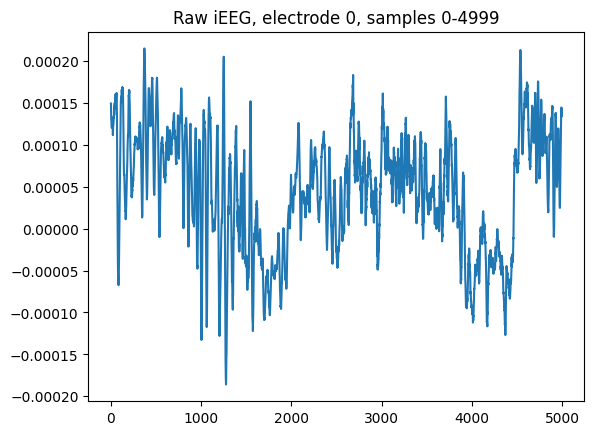

In [8]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [12]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/{subject_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]
elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCaS1,A32sg_L,-5.191163,49.370031,6.599996,-6.001400,36.336286,-2.597083,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCaS2,A32sg_L,-5.989805,52.168332,10.599996,-6.763325,39.497124,1.356690,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,NaN
2,LaCaS3,A32sg_L,-6.389126,54.966633,14.599995,-7.045588,42.755355,5.353050,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,NaN
3,LaCaS4,A32sg_L,-7.187768,57.764934,18.599995,-7.908159,45.967553,9.362542,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus F,WM,NaN
4,LaCaS5,A10m_L,-7.986409,60.563235,22.599995,-8.693478,49.173177,13.406068,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L Superior Medial Gyrus,L SFG,Left frontal pole 4 A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,RpIS112,Unknown,35.539562,-34.179237,72.199992,45.397519,-35.816711,84.571360,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
182,uLAglT,rHipp_L,-16.372147,8.594790,-13.000003,-18.226673,-6.104086,-19.641039,Gray,Left Amygdala,Amygdala (SF),L Hippocampus,L Hipp,Left amygdala superior,NaN,NaN
183,uLmOlF,A11m_L,-6.788447,48.170759,-13.400003,-7.358504,33.495630,-25.317349,Gray,Left GRe gyrus rectus,Area Fo1,L Superior Orbital Gyrus,L OrG,Left frontal orbital 4 A,NaN,NaN
184,uRAglT,rHipp_R,13.976237,6.995761,-15.800003,17.141796,-6.783901,-23.851153,Gray,Right Hippocampus,Subiculum,R ParaHippocampal Gyrus,R Hipp,Right hippocampus pes,NaN,NaN


In [13]:
elec_locs.label # pulls electrode names

0       LaCaS1
1       LaCaS2
2       LaCaS3
3       LaCaS4
4       LaCaS5
        ...   
181    RpIS112
182     uLAglT
183     uLmOlF
184     uRAglT
185     uRmOlF
Name: label, Length: 186, dtype: object

In [14]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)

In [15]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}
new_name_dict

In [17]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS018.edf, 276 x 631040 (616.2 s), ~1.30 GB, data loaded>

In [18]:
unmatched_seeg #make sure there are no unmatched names

[]

In [19]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'research', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [20]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 92 left & 91 right sEEG electrodes
We have a total of 183 sEEG electrodes


In [23]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names)) # it is either called DC1 or research
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS018.edf, 183 x 631040 (616.2 s), ~881.2 MB, data loaded>

In [25]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'research':'stim'} 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS018.edf, 183 x 631040 (616.2 s), ~881.2 MB, data loaded>

In [26]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS018.edf, 183 x 631040 (616.2 s), ~881.3 MB, data loaded>

### Notch filter line noise

In [27]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:    2.0s finished


<RawEDF | MS018.edf, 183 x 631040 (616.2 s), ~881.3 MB, data loaded>

### Resampling data 

In [28]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:    3.2s finished


<RawEDF | MS018.edf, 183 x 308125 (616.2 s), ~430.4 MB, data loaded>

### Bad Channel Removal (manual)

Let's pick out any bad channels missed by automatic screening (visual inspection as a reference), or restore channels that were erroneously deemed bad. You have to press the "power" button twice (once for the plot and once for the panel beneath it) when you're done so that you're manual changes are saved.

<IPython.core.display.Javascript object>


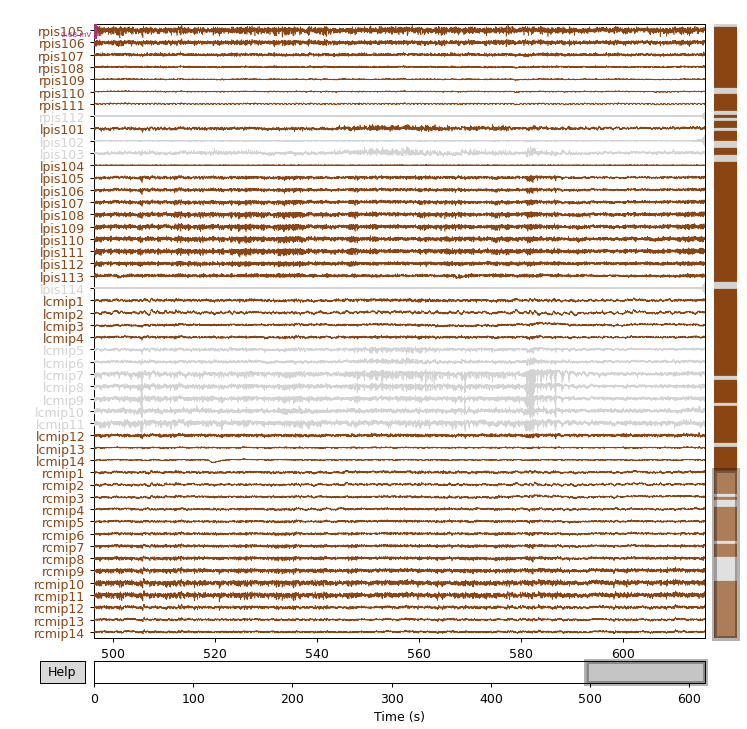

<IPython.core.display.Javascript object>


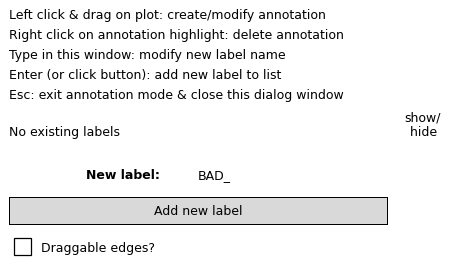

In [80]:
%matplotlib notebook
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [82]:
mne_data.info['bads'] #sanity check that bads info saved
len(mne_data.info['bads']) # number of bad electrodes 

26

## Save raw LFP data
Notch filtered and resampled with bad elecs indicated

In [54]:
#define oob elecs as bad before saving out lfp file 
oob_elec = [elec_locs['label'].iloc[ind].lower() for ind, data in elec_locs['Manual Examination'].str.lower().items() if data=='oob']
oob_elec

['lacas9',
 'lacas10',
 'laglt9',
 'laisf14',
 'laisf15',
 'laisf16',
 'lcmip13',
 'lcmip14',
 'lhplt10',
 'lmcms9',
 'lmcms10',
 'lpis113',
 'lpis114',
 'racas11',
 'racas12',
 'raglt9',
 'raisf15',
 'raisf16',
 'rcmip13',
 'rcmip14',
 'rhplt9',
 'rhplt10',
 'rpis108',
 'rpis109',
 'rpis110',
 'rpis111',
 'rpis112']

In [55]:
bad_ch= mne_data.info['bads']
bad_ch = bad_ch + oob_elec
mne_data.info['bads'] = bad_ch
mne_data.info['bads'] # make sure an WM referenced pairs that include these channels is excluded. 

['lcmip9',
 'research',
 'lcmip5',
 'lcmip6',
 'lcmip7',
 'lcmip8',
 'lcmip10',
 'lcmip11',
 'lpis104',
 'lcmip12',
 'lcmip13',
 'lcmip14',
 'lpis101',
 'lpis102',
 'lpis103',
 'lhplt2',
 'racas12',
 'racas11',
 'racas8',
 'racas6',
 'lacas8',
 'raisf1',
 'rpis112',
 'raisf13',
 'lpis114',
 'lacas9',
 'lacas10',
 'laglt9',
 'laisf14',
 'laisf15',
 'laisf16',
 'lcmip13',
 'lcmip14',
 'lhplt10',
 'lmcms9',
 'lmcms10',
 'lpis113',
 'lpis114',
 'racas11',
 'racas12',
 'raglt9',
 'raisf15',
 'raisf16',
 'rcmip13',
 'rcmip14',
 'rhplt9',
 'rhplt10',
 'rpis108',
 'rpis109',
 'rpis110',
 'rpis111',
 'rpis112']

In [57]:
mne_data.save(f'{neural_dir}/raw_ieeg.fif',overwrite=True)

# Rereference data - Both WM ref and Bipolar ref!

### WM REF

In [83]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [ ]:
# not super elegant way to do this, but it works
anode_list_clean = []
removed_anode_index = []
for i,ch in enumerate(anode_list):
    if ch not in bad_ch:
        anode_list_clean.append(ch)
    else:
        removed_anode_index.append(i)

cathode_list_update = [cathode_list[i] for i in range(len(cathode_list)) if i not in removed_anode_index]

cathode_list_clean = []
for ch in cathode_list_update:
    if ch not in bad_ch:
        cathode_list_clean.append(ch)

In [ ]:
mne_data_wm_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

To start annotating, press 'Add new label' in the bottom panel. Then left click and drag around window of interest. 

<IPython.core.display.Javascript object>


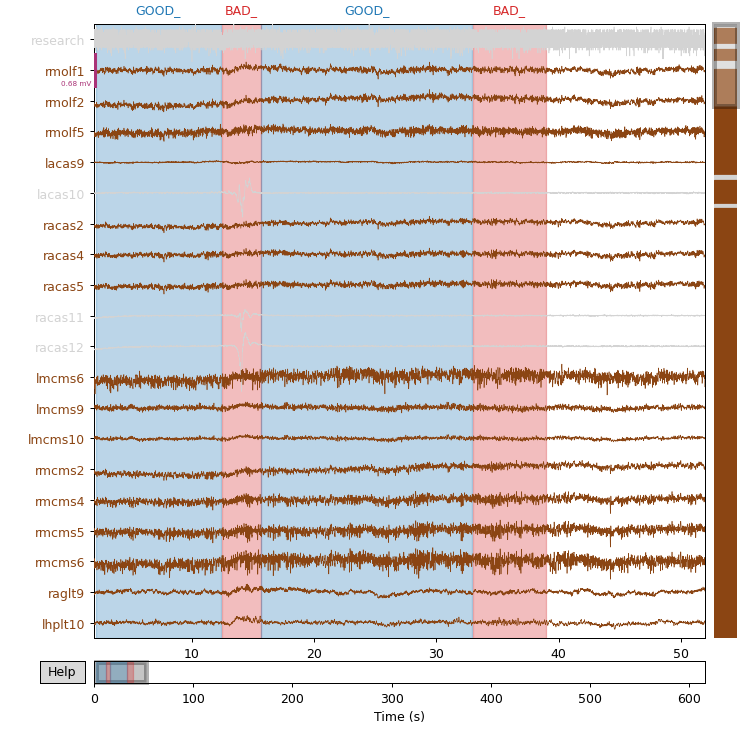

<IPython.core.display.Javascript object>


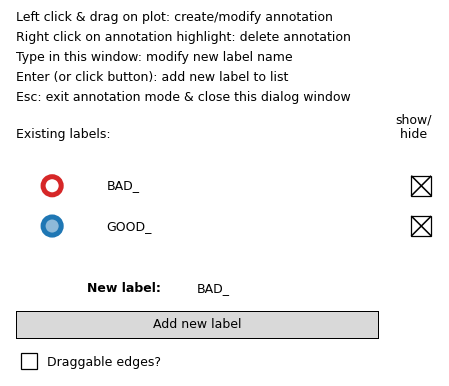

In [ ]:
%matplotlib notebook
%matplotlib notebook
# use the epoch code to select only the WM referenced pairs
fig = mne_data_wm_reref.plot(start=2, duration=50, n_channels=20,scalings=mne_data._data.max()/20 ) # plot all channels at once
fig.fake_keypress("a")

In [ ]:
# source: https://mne.discourse.group/t/removing-time-segments-from-raw-object-without-epoching/4169/2
# WIP - figure out a more efficient way to do this without needing to annotate all good. 
def reject_bad_segs(raw):
    """ This function rejects all time spans annotated as 'BAD_' and concatenates the rest"""
    raw_segs = []
    for jsegment in range(len(raw.annotations)):
        if raw.annotations.description[jsegment] != 'BAD_':  # Append all other than 
            raw_segs.append(raw.copy().crop(tmin=raw.annotations.onset[jsegment], tmax=raw.annotations.onset[jsegment+1],
            include_tmax=False))
    return mne.concatenate_raws(raw_segs)

In [ ]:
clean_data = reject_bad_segs(mne_data_wm_reref)

In [ ]:
clean_data

<RawEDF | MS018.edf, 150 x 13798 (27.6 s), ~16.0 MB, data loaded>

## Save reref data

In [ ]:
mne_data_wm_reref.save(f'{neural_dir}/MS002/wm_ref_ieeg.fif',overwrite=True)